In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import gsw
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.preprocessing import LabelEncoder
import glasbey
from matplotlib.colors import ListedColormap

%matplotlib inline

# Liu and Tanhua

Data for the paper
- https://www.ncei.noaa.gov/access/ocean-carbon-acidification-data-system/oceans/ndp_107/ndp107.html
- https://omp.geomar.de/watermass.html

In [ ]:
df = pd.read_csv("../../data/province_shapes/liu/Atlantic_WMs_GLODAPv2.csv", encoding='unicode_escape', header=[0, 1])

In [ ]:
# pressure to depth conversion
df["LEV_M"] = gsw.conversions.z_from_p(p=df["Pressure", "dbar"], lat=df["Latitude", "deg"])*(-1)

In [ ]:
# they measured to what fraction each surce water contributed to a geographic location - here we take the highest fraction as the water mass
df["main_wm"] = df[[('ENACW', 'Unnamed: 7_level_1'), ('WNACW','WM fraction'), ('ESACW','WM fraction'), ('WSACW', 'WM fraction'), 
                    ('AAIW', 'WM fraction'), ('SAIW', 'WM fraction'), ('MW', 'WM fraction'), ('upper NADW', 'WM fraction'), 
                    ('lower NADW', 'WM fraction'), ('LSW', 'WM fraction'), ('ISOW', 'WM fraction'), ('DSOW', 'WM fraction'),
                    ('AABW', 'WM fraction'), ('NEABW', 'WM fraction'), ('CDW', 'WM fraction'), ('WSBW', 'WM fraction')]].apply(
                    lambda x: x.idxmax()[0], axis=1)

In [ ]:
# convert main water mass types to categorical labels
le = LabelEncoder()
label = le.fit_transform(df.main_wm)
df["label"] = label

In [ ]:
# define color map and ranges
unique_labels = np.sort(df.main_wm.unique())
colors = glasbey.create_palette(palette_size=len(unique_labels))
cm = ListedColormap(colors)  

vmin = 0
vmax = len(unique_labels)

cm

In [ ]:
# defining out area and inspecting deep North Atlantic
lat_min = 0
lat_max = 70

lon_min = -77
lon_max = 30
# lat_min = df.Latitude.deg.min()
# lat_max = df.Latitude.deg.max()

# lon_min = df.Longitude.deg.min()
# lon_max = df.Longitude.deg.max()

depths = [0.,   50.,  100.,  200.,  300.,  400.,  500., 1000., 1500., 2000., 3000., 4000., 5000]

# select above area from df and set basic plotting parameters
df_na = df[(df.Longitude.deg <= lon_max) &  (df.Longitude.deg >= lon_min) & (df.Latitude.deg <= lat_max) & (df.Latitude.deg >= lat_min)]
mymap = Basemap(llcrnrlon=lon_min, llcrnrlat=lat_min, urcrnrlon=lon_max, urcrnrlat=lat_max)
plt.rcParams["figure.figsize"] = ((lon_max - lon_min)/10, (lat_max - lat_min)/10)

def plot_wms_over_depth(depth_level):
    # filter for depth
    temp = df_na[(df_na.LEV_M >= depths[depth_level]) & (df_na.LEV_M < depths[depth_level + 1])]
    print(depths[depth_level], depths[depth_level+1])

    # plot
    fig, ax = plt.subplots()
    ax.scatter(temp["Longitude"].deg, temp["Latitude"].deg, c=temp["label"],s=1, cmap=cm, vmin=vmin, vmax=vmax)
    mymap.drawcoastlines(linewidth=0.5)
    mymap.fillcontinents()

interact(plot_wms_over_depth, depth_level=widgets.IntSlider(value=0, min=0, max=len(depths)-2, step=1))

plt.show()

In [ ]:
df

In [ ]:
# alternative (characterise your data with this)
# df = pd.read_excel("../../data/province_shapes/liu/os-17-463-2021-t02.xlsx")
dfs = pd.DataFrame({"Layer": 4*["upper"] + 3*["intermediate"] + 5*["deep and overflow"] + 4*["bottom"],
                   "SWT": ["ENACW", "WNACW", "ESACW", "WSACW", "AAIF", "SAIW", "MW", "uNADW", "INADW", "LSW", "ISOW", "DSOW", "AABW", "CDW", "WSBW", "NEABW"],
                   "lon_min": [-35, -70, 0, -60, -55, -55, -24, -50, -50, -60, -45, -46, np.nan, 60, np.nan, -45],
                   "lon_max": [-20, -50, 15, -25, -25, -35, -6, -32, -32, -24, 0, -19, np.nan, np.nan, np.nan, -10],
                   "lat_min": [39, 24, -40, -45, -60, 50, 33, 40, 40, 48, 50, 55, np.nan, -65, -65, 0],
                   "lat_max": [48, 37, -30, -30, -45, 60, 48, 50, 50, 66, 66, 66, -63, -55, -55, 30],
                   "pressure_dbar_min": [100, 100, 200, 100, 100, 100, 300, 1200, 2000, 500, 1500, 1500, np.nan, 200, 3000, 4000],
                   "pressure_dbar_max": [500, 500, 700, 1000, 300, 500, np.nan, 2000, 3000, 2000, 3000, np.nan, np.nan, 1000, 6000, np.nan],
                   "cons_temperature_min": [np.nan, np.nan, np.nan, np.nan, np.nan, 4.5, np.nan, np.nan, 2.5, np.nan, 2.2, np.nan, np.nan, -0.5, np.nan, 1.8],
                   "cons_temperature_max": [np.nan, np.nan, np.nan, np.nan, 3.5, np.nan, np.nan, 4.0, np.nan, 4.0, 3.3, 2.0, np.nan, -1, -0.7, np.nan],
                   "abs_salinity_min": [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 36.5, np.nan, np.nan, np.nan, 34.95, np.nan, np.nan, 34.82, np.nan, np.nan],
                   "abs_salinity_max": [np.nan, np.nan, np.nan, np.nan, 34.4, np.nan, 37.0, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                   "neutral_density_min": [26.5, 26.2, 26, 26, 26.95, 27.7, np.nan, 27.85, 27.9, 27.7, 28, 28.15, 28.2, 28.1, np.nan, np.nan],
                   "neutral_density_max": [27.3, 26.7, 27.5, 27, 27.5, np.nan, np.nan, 28.05, 28.1, 28.1, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                   "oxygen_min": [np.nan, np.nan, 200, np.nan, 260, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 220, np.nan, np.nan, np.nan],
                   "oxygen_max": [np.nan, np.nan, 230, 230, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                   "silicate_min": [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 120, np.nan, np.nan, np.nan],
                   "silicate_max": [np.nan, 2, 8, 5, 30, np.nan, np.nan, np.nan, np.nan, np.nan, 18, np.nan, np.nan, np.nan, np.nan, np.nan]
                  })
# units: cons_temperature [°C], abs_salinity [g kg-1], neutral_density [kg m-3], oxygen [umol kg-1], silicate [umol kg.1]
dfs.head()

In [ ]:
dfs.head()

In [ ]:
df_my = pd.read_csv("output_final/dbscan/uncertainty/umap_dbscan_7.csv")

In [ ]:
# compute pressure in dbar
df_my["pressure"] = gsw.p_from_z(z=df_my.LEV_M*-1, lat=df_my.LATITUDE, geo_strf_dyn_height=0, sea_surface_geopotential=0)

In [ ]:
# compute absolute salinity
df_my["abs_salinity"] = gsw.SA_from_SP(SP=df_my.P_SALINITY, p=df_my.pressure, lon=df_my.LONGITUDE, lat=df_my.LATITUDE)

In [ ]:
# compute conservative temperature
df_my["cons_temperature"] = gsw.CT_from_pt(SA=df_my.abs_salinity, pt=df_my.P_TEMPERATURE)

In [ ]:
# compute neutral density
df_my["neutral_density"] = 0  # @todo

In [ ]:
def map_wm(row):
    for wm_row in dfs.iterrows():
        
        # longitude
        lon_min = wm_row[1].lon_min
        if pd.isna(lon_min):
            lon_min = df_my.LONGITUDE.min()
        
        lon_max = wm_row[1].lon_max
        if pd.isna(lon_max):
            lon_max = df_my.LONGITUDE.max()
            
        # latitude
        lat_min = wm_row[1].lat_min
        if pd.isna(lat_min):
            lat_min = df_my.LATITUDE.min()
        
        lat_max = wm_row[1].lat_max
        if pd.isna(lat_max):
            lat_max = df_my.LATITUDE.max()
        
        # pressure
        pressure_dbar_min = wm_row[1].pressure_dbar_min
        if pd.isna(pressure_dbar_min):
            pressure_dbar_min = df_my.pressure.min()
        
        pressure_dbar_max = wm_row[1].pressure_dbar_max
        if pd.isna(pressure_dbar_max):
            pressure_dbar_max = df_my.pressure.max()
        
        # temperature
        cons_temperature_min = wm_row[1].cons_temperature_min
        if pd.isna(cons_temperature_min):
            cons_temperature_min = df_my.cons_temperature.min()
        
        cons_temperature_max = wm_row[1].cons_temperature_max
        if pd.isna(cons_temperature_max):
            cons_temperature_max = df_my.cons_temperature.max()
        
        # salinity
        abs_salinity_min = wm_row[1].abs_salinity_min
        if pd.isna(abs_salinity_min):
            abs_salinity_min = df_my.abs_salinity.min()
        
        abs_salinity_max = wm_row[1].abs_salinity_max
        if pd.isna(abs_salinity_max):
            abs_salinity_max = df_my.abs_salinity.max()

        # neutral density
        neutral_density_min = wm_row[1].neutral_density_min
        if pd.isna(neutral_density_min):
            neutral_density_min = df_my.neutral_density.min()
        
        neutral_density_max = wm_row[1].neutral_density_max
        if pd.isna(neutral_density_max):
            neutral_density_max = df_my.neutral_density.max()
            
        # oxygen
        oxygen_min = wm_row[1].oxygen_min
        if pd.isna(oxygen_min):
            oxygen_min = df_my.P_OXYGEN.min()
        
        oxygen_max = wm_row[1].oxygen_max
        if pd.isna(oxygen_max):
            oxygen_max = df_my.P_OXYGEN.max()       
        
        # silicate
        silicate_min = wm_row[1].silicate_min
        if pd.isna(silicate_min):
            silicate_min = df_my.P_SILICATE.min()
        
        silicate_max = wm_row[1].silicate_max
        if pd.isna(silicate_max):
            silicate_max = df_my.P_SILICATE.max()
            
        if row.LONGITUDE >= lon_min and row.LONGITUDE <= lon_max \
        and row.LATITUDE >= lat_min and row.LATITUDE <= lat_max \
        and row.pressure >= pressure_dbar_min and row.pressure <= pressure_dbar_max \
        and row.cons_temperature >= cons_temperature_min and row.cons_temperature <= cons_temperature_max \
        and row.abs_salinity >= abs_salinity_min and row.abs_salinity <= abs_salinity_max \
        and row.neutral_density >= neutral_density_min and row.neutral_density <= neutral_density_max \
        and row.P_OXYGEN >= oxygen_min and row.P_OXYGEN <= oxygen_max \
        and row.P_SILICATE >= silicate_min and row.P_SILICATE <= silicate_max:
            return wm_row[1].SWT
        
    return -1

In [ ]:
df_my["wm"] = df_my.apply(map_wm, axis=1)
df_my.wm.value_counts()

In [ ]:
import utils
df_my.wm = pd.Categorical(df_my.wm)
df_my["code"] = df_my.wm.cat.codes
df_my = utils.color_code_labels(df=df_my, column_name="code")

In [ ]:
utils.coupled_label_plot(df_my)

# Tomzak and Godfrey

In [ ]:
# Antarctic Bottom Water (AABW)
- LEV_M < 4000m
- spreads norrthward from circumpolar current (both sides of Mid-Atlantic Ridge) - east: stop at Walvis Ridge, west: past 50°N
- enters eastern basin through Romanche Fracture Zone

# Arctic Bottom Water (ABW)
- vicinity of the Greenland-Iceland-Scotland Ridge
- contributes to formation of NADW

# North Atlantic Deep Water (NADW)
- Depth range between 1000 and 4000m 
- salinity > 34.9
- oxygen > 5.5 ml/l
- 2 oxygen maxima in the subtropics (indicates 2 distinct deep water varieties)
    - Upper maximum (2000 - 3000 m)
        - Traceable to surface near 55°N (reflexts spreading of NADW formed by mixing ABW and the product of deep winter convection in Labrador Sea
    - Lower maximum (3500 - 4000 m)
        - Origin in Greenland-Iceland-Scotland overflow region
        - Indicates that some Deep Water is formed before the ABW reaches the Labrador Sea through mixing of overflow water with surrounding waters
        - "lower" or "eastern" NADW (prominent in eastern basins)
- Deep Water of Labardor Sea origin (middle/western NADW) is less dense than ENADW
- ENADW and WNADW remain vertically layered along their southward path
- "Upper" NADW
    - This is NADW from the Larador Sea with traces of the EMW
                            
# Labrador Sea Water
- Temperatures of 3-3.6°C
- Salinities of 34.86 - 34.96
- High oxygen
- Product of winter convection (not annual!)

# Eurafrican Mediterranean Water (EMW)
- Leaves Stait of Gibraltar with a temperature of about 13.5 °C, salinity of 37.8
- T, S reduces by mixing within less than 250 km
- Spreads isopycnically across the ocean 
- At around 1000 m depth (near upper NADW limit)       
- Carried northward along Portuguese shelf 
- Mixes into subtropical gyre ciruculation spreading south and west                                          
- Core of TS anomaly sinks as water spreads (at 2000 m, traces of EMW are seen all across North Atlantic)
- Some high salinity water crossing the equator in the west and proceeding southward                                         
                                          
# Antarctic Circumpolar Water

# Antarctic Intermediate Water (AAIW)

# Arctic Intermediate Water (AIW)


# Emery

In [28]:
dfe = pd.DataFrame({"Layer": 4*["upper"] + 5*["intermediate"] + 3*["deep and abyssal"],
                   "WM": ["ASUW", "WNACW", "ENACW", "SACW", "WASIW", "EASIW", "AAIW", "MW", "AIW", "NADW", "AABW", "ABW"],
                   "pot_temperature_min": [0, 7, 8, 5, 3, 3, 2, 2.6, -1.5, 1.5, -0.9, -10.5],
                   "pot_temperature_max": [4, 20, 18, 18, 9, 9, 6, 11, 3, 4, 1.7, -1.8],
                   "salinity_min": [34, 35, 35.2, 34.3, 34, 34.4, 33.8, 35, 34.7, 34.8, 34.64, 34.88],
                   "salinity_max": [35, 36.7, 36.7, 35.8, 35.1, 35.3, 34.8, 36.2, 34.9, 35, 34.72, 34.94],
                   "depth_min": [0, 0, 0, 0, 500, 500, 500, 500, 500, 1500, 1500, 1500],
                   "depth_max": [500, 500, 500, 500, 1500, 1500, 1500, 1500, 1500, 12000, 12000, 12000],
                  })
# units: pot_temperature [°C], salinity [‰] == [psu], depth [m]
dfe # .head()

,Layer,WM,pot_temperature_min,pot_temperature_max,salinity_min,salinity_max,depth_min,depth_max
0,upper,ASUW,0.0,4.0,34.00,35.00,0,500
1,upper,WNACW,7.0,20.0,35.00,36.70,0,500
2,upper,ENACW,8.0,18.0,35.20,36.70,0,500
3,upper,SACW,5.0,18.0,34.30,35.80,0,500
4,intermediate,WASIW,3.0,9.0,34.00,35.10,500,1500
5,intermediate,EASIW,3.0,9.0,34.40,35.30,500,1500
6,intermediate,AAIW,2.0,6.0,33.80,34.80,500,1500
7,intermediate,MW,2.6,11.0,35.00,36.20,500,1500
8,intermediate,AIW,-1.5,3.0,34.70,34.90,500,1500
9,deep and abyssal,NADW,1.5,4.0,34.80,35.00,1500,12000


In [29]:
df_my = pd.read_csv("output_final/dbscan/uncertainty/umap_dbscan_7.csv")

In [31]:
def map_wm(row):
    for wm_row in dfe.iterrows():        
        # depth
        depth_min = wm_row[1].depth_min
        if pd.isna(depth_min):
            depth_min = df_my.LEV_M.min()
        
        depth_max = wm_row[1].depth_max
        if pd.isna(depth_max):
            depth_max = df_my.LEV_M.max()
        
        # temperature
        pot_temperature_min = wm_row[1].pot_temperature_min
        if pd.isna(pot_temperature_min):
            pot_temperature_min = df_my.P_TEMPERATURE.min()
        
        pot_temperature_max = wm_row[1].pot_temperature_max
        if pd.isna(pot_temperature_max):
            pot_temperature_max = df_my.P_TEMPERATURE.max()
        
        # salinity
        salinity_min = wm_row[1].salinity_min
        if pd.isna(salinity_min):
            salinity_min = df_my.P_SALINITY.min()
        
        salinity_max = wm_row[1].salinity_max
        if pd.isna(salinity_max):
            salinity_max = df_my.P_SALINITY.max()
            
        if row.LEV_M >= depth_min and row.LEV_M <= depth_max \
        and row.P_TEMPERATURE >= pot_temperature_min and row.P_TEMPERATURE <= pot_temperature_max \
        and row.P_SALINITY >= salinity_min and row.P_SALINITY <= salinity_max:
            return wm_row[1].WM
        
    return -1

In [32]:
12094/len(df_my)*100

24.61582300380615

In [33]:
df_my["wm"] = df_my.apply(map_wm, axis=1)
df_my.wm.value_counts()

wm
WNACW    15582
-1       12094
NADW      7605
WASIW     5937
SACW      4423
ASUW      2103
EASIW      823
MW         524
AIW         37
AAIW         3
Name: count, dtype: int64

In [34]:
import utils
df_my.wm = pd.Categorical(df_my.wm)
df_my["code"] = df_my.wm.cat.codes
df_my = utils.color_code_labels(df=df_my, column_name="code")

## Upper waters
- **ASUW** (pink)
    - Should have taken an L-form connecting Labrador Sea, Iceland and including North and Baltic Seas
- **ENACW**
    - Not detected at all
- **WNACW** (dark blue)
    - It was supposed to be WEST Atlantic (but detected in east)
- **SACW** (orange)
    - Detected below surface and in the north (where ASUW was supposed to be)

## Intermediate waters 
- **MW** (bright green)
    - Paper corresponds to this mapping
- **WASIW** (brown)
    - Paper corresponds to this mapping
- **EASIW** (purple)
    - Paper roughly corresponds to this mapping
- **AIW** (green) 
    - Some scattered points in the north
- **AAIW** (blue)
    - Some scattered points in the north (weird, should be south)

## Deep and abyssal waters
- **NADW** (turquoise)
    - Fills all bottom water below 1500 m
- **AABW** and **ABW**
    - Not detected.

In [35]:
df_my.groupby("wm").first().color

wm
-1       #d21820
AAIW     #1869ff
AIW      #008a00
ASUW     #f36dff
EASIW    #710079
MW       #aafb00
NADW     #00bec2
SACW     #ffa235
WASIW    #5d3d04
WNACW    #08008a
Name: color, dtype: object

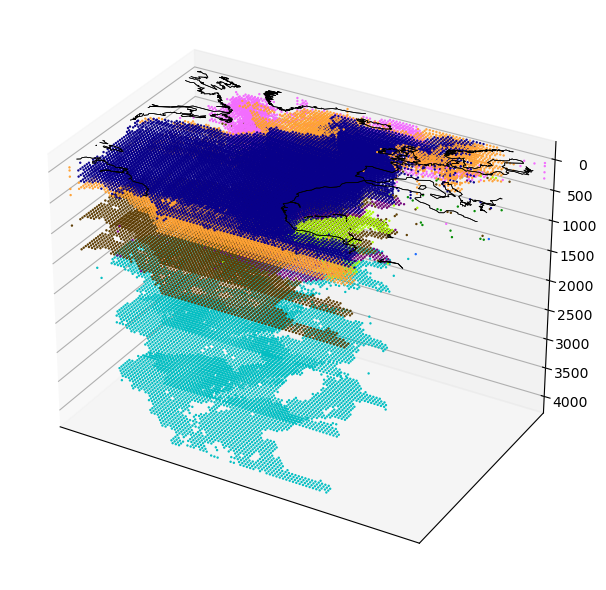

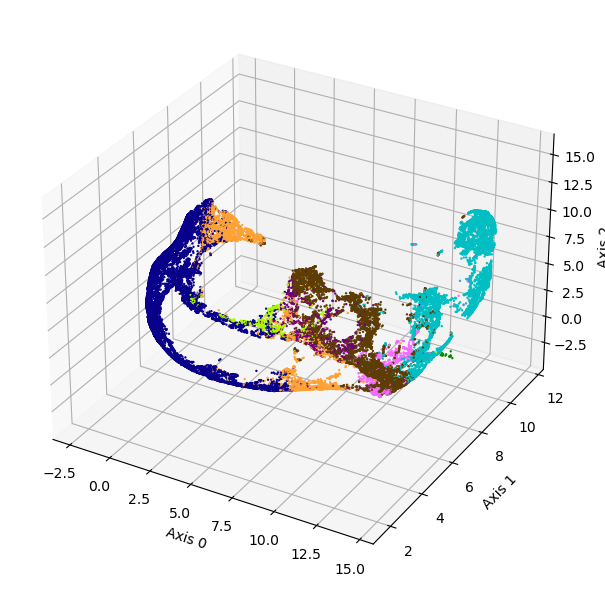

In [36]:
upper_waters = dfe[dfe.Layer == "upper"].WM.unique()
intermediate_waters = dfe[dfe.Layer == "intermediate"].WM.unique() 
deep_waters = dfe[dfe.Layer == "deep and abyssal"].WM.unique()
custom = ["AIW", "AAIW"]

utils.coupled_label_plot(df_my[df_my.wm != -1]) # df_my[df_my.wm.isin(upper_waters)])  # df_my[df_my.wm != -1])

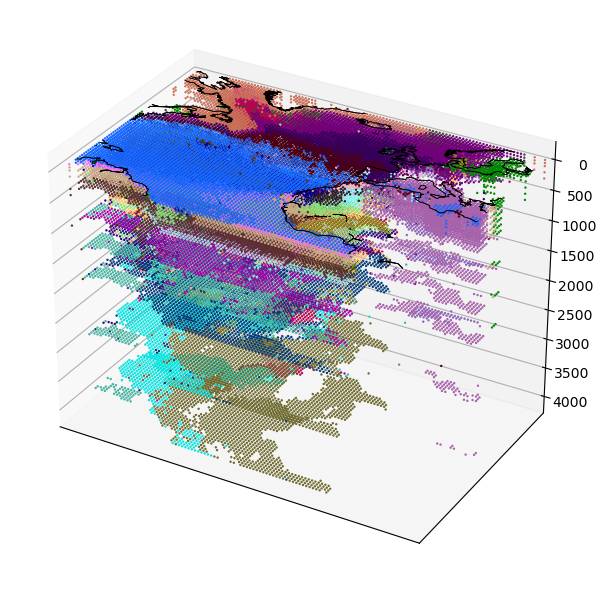

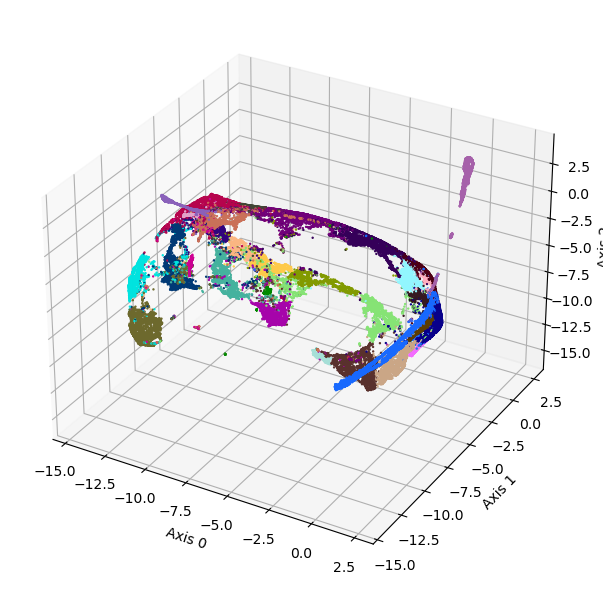

In [25]:
df = pd.read_csv("re-assigned_aa.csv")
utils.coupled_label_plot(df)